# Módulo 1: Utilización, procesamiento y visualización de grandes volúmenes de datos (Portafolio Análisis)
## 💻 Inteligencia artificial avanzada para la ciencia de datos II (Gpo 501)

# **CLASIFICADOR BINARIO US ACCIDENTS**

Este es un modelo de clasificación binaria con regresión logística con PySpark y MLlib para predecir si un accidente será leve o grave utilizando el dataset [US Accidents (2016-2023)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data) de Kaggle.

El modelo usa variables meteorológicas y de visibilidad como Temperature(F), Humidity(%), Pressure(in), Visibility(mi) y Wind_Speed(mph). La etiqueta se definió como label = 1 si Severity ≥ 3 (grave) y label = 0 en caso contrario (leve).

El objetivo propuesto para este proyecto es lograr ≥ 0.80 de accuracy en test para clasificar la gravedad de accidentes (leve vs grave).

### Configuración y descarga de datos
Configurar el entorno en Colab, instalar PySpark e importar el dataset de Kaggle para trabajar con un archivo grande. Este dataset es adecuado para MLlib porque tiene una gran cantidad de filas y suficientes variables ambientales y contextuales que suelen correlacionarse con la gravedad de un accidente.

In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sobhanmoosavi/us-accidents -p /content/us_accidents
!unzip -q /content/us_accidents/*.zip -d /content/us_accidents

!pip install pyspark==3.5.0
!ls -lh /content/us_accidents

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
 96% 628M/653M [00:03<00:00, 138MB/s] 
100% 653M/653M [00:03<00:00, 204MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=a9cbb92d578ec1cdd845ea2dbae309269789649adc9c941024a39d16f1ba384d
  Stored in directory: /root/.cache/pip/wheels/84/40/20/65eefe766118e0a8f8e385cc3ed6e9eb7241c7e51cfc04c51a
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pysp

In [2]:
# instalar OpenJDK 11
!apt-get -y update
!apt-get -y install openjdk-11-jdk-headless > /dev/null

import os, sys, subprocess, platform
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
print("JAVA_HOME =", os.environ["JAVA_HOME"])
!java -version

# construir sesión de spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("clasificador de accidentes US").getOrCreate()
spark

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,102 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://cli.github.com/packages stable/main amd64 Packag

In [3]:
# importar librerías
from pyspark.sql.functions import when, col
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import count
from pyspark.sql.functions import sum as spark_sum

### Carga del CSV y vista inicial

Cargar el CSV con inferSchema=True y mostrar un subconjunto de columnas relevantes para verificar que el esquema es coherente (mediciones climáticas numéricas, Severity existe) y evitar errores posteriores (nulos inesperados, tipos string donde deben ser floats).

In [4]:
df = spark.read.option("header", True).option("inferSchema", True).csv("/content/us_accidents/US_Accidents_March23.csv")
print("número de filas:", df.count())
df.printSchema()
df.select("ID", "Severity", "State", "Temperature(F)", "Humidity(%)", "Visibility(mi)", "Wind_Speed(mph)").show(5)

número de filas: 7728394
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double

### Creación de la etiqueta binaria y selección de columnas

Transformar la etiqueta a binaria: label = 1 si el accidente es grave (3-4) y 0 si es leve (1-2) alineando el problema con una clasificación binaria estándar.

Seleccionar un subset mínimo de columnas numéricas robustas para mantener el modelo simple y con menor riesgo de fuga de memoria.

In [5]:
# etiqueta binaria leve 1-2 y grave 3-4
df = df.withColumn("label", when(col("Severity") <= 2, 0).otherwise(1))

cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)"]

# eliminar filas con valores nulos
df = df.select(["label"] + cols).na.drop()
df.show(5)

+-----+--------------+-----------+------------+--------------+---------------+
|label|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|
+-----+--------------+-----------+------------+--------------+---------------+
|    0|          36.0|      100.0|       29.67|          10.0|            3.5|
|    1|          35.1|       96.0|       29.64|           9.0|            4.6|
|    0|          36.0|       89.0|       29.65|           6.0|            3.5|
|    1|          37.9|       97.0|       29.63|           7.0|            3.5|
|    0|          34.0|      100.0|       29.66|           7.0|            3.5|
+-----+--------------+-----------+------------+--------------+---------------+
only showing top 5 rows



In [ ]:
"""
features no lineales

df = df.withColumn("is_low_visibility", when(col("Visibility(mi)") < 1.0, 1).otherwise(0))
df = df.withColumn("is_high_wind",      when(col("Wind_Speed(mph)") > 20.0, 1).otherwise(0))
df = df.withColumn("is_high_humidity",  when(col("Humidity(%)")    > 90.0, 1).otherwise(0))
df = df.withColumn("is_extreme_temp",   when((col("Temperature(F)") < 32) | (col("Temperature(F)") > 95), 1).otherwise(0))

cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)",
        "is_low_visibility","is_high_wind","is_high_humidity","is_extreme_temp"]

df = df.select(["label"] + cols).na.drop()
df.show(5)
"""

### Vectorización y partición Train/Test

Construir features con Vectors.dense([...]) y convertir cada fila a un Row(label=…, features=…). Separar en train/test (80/20) para evaluar fuera de muestra.

In [6]:
# columna de características
def row_to_features(row):
    return Row(label=row["label"], features=Vectors.dense([
        row["Temperature(F)"],
        row["Humidity(%)"],
        row["Pressure(in)"],
        row["Visibility(mi)"],
        row["Wind_Speed(mph)"]
    ]))

rdd = df.rdd.map(row_to_features)
data = spark.createDataFrame(rdd)

# train/test split
train, test = data.randomSplit([0.8, 0.2], seed=42)
print("Train:", train.count(), " Test:", test.count())

Train: 5677391  Test: 1418296


In [ ]:
"""
leve undersampling

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print("Split → train:", train_df.count(), " test:", test_df.count())

frac_leves = 0.10  # 10% de los leves
train_pos = train_df.filter(col("label")==1)
train_neg = train_df.filter(col("label")==0).sample(False, frac_leves, seed=42)
train_df_bal = train_pos.union(train_neg)
print("Train balanceado:", train_df_bal.count())

rdd_train = train_df_bal.rdd.map(row_to_features)
rdd_test  = test_df.rdd.map(row_to_features)
data_train = spark.createDataFrame(rdd_train)
data_test  = spark.createDataFrame(rdd_test)
print("data_train:", data_train.count(), " data_test:", data_test.count())
"""

In [7]:
from pyspark.sql import functions as F

df_raw = spark.read.option("header", True).option("inferSchema", True)\
    .csv("/content/us_accidents/US_Accidents_March23.csv")

df_raw = df_raw.withColumn("label", when(col("Severity") <= 2, 0).otherwise(1))

tableau_df = df_raw.selectExpr(
    "`State` as State",
    "`label` as is_grave",
    "`Temperature(F)` as Temperature_F",
    "`Humidity(%)` as Humidity_pct",
    "`Pressure(in)` as Pressure_in",
    "`Visibility(mi)` as Visibility_mi",
    "`Wind_Speed(mph)` as Wind_Speed_mph"
).na.drop(subset=["State","Temperature_F","Humidity_pct","Pressure_in","Visibility_mi","Wind_Speed_mph","is_grave"])

tableau_df = tableau_df.sample(False, 0.10, seed=42)  # 10%

out_dir = "/content/USaccidents_for_tableau"
tableau_df.coalesce(1).write.mode("overwrite").option("header", True).csv(out_dir)

import glob, shutil
src = glob.glob(out_dir + "/part-*.csv")[0]
dst = "/content/USaccidents.csv"
shutil.copy(src, dst)

from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Entrenamiento de LogisticRegression y predicción

Usar LogisticRegression --> modelo base interpretable y eficiente para grandes volúmenes.

Generar las predicciones en el set de prueba incluyendo la probabilidad por clase.

In [8]:
# entrenamiento del modelo
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
model = lr.fit(train)

# predicciones
pred = model.transform(test)
pred.select("label", "prediction", "probability").show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.78883763718297...|
|    0|       0.0|[0.78865894746804...|
|    0|       0.0|[0.79502468294765...|
|    0|       0.0|[0.78007225799177...|
|    0|       0.0|[0.77453345951814...|
|    0|       0.0|[0.76969415911479...|
|    0|       0.0|[0.78125309738011...|
|    0|       0.0|[0.78453167260389...|
|    0|       0.0|[0.79214255726914...|
|    0|       0.0|[0.76799513924396...|
+-----+----------+--------------------+
only showing top 10 rows



### Métricas

Calcular accuracy y AUC (ROC) para medir rendimiento general.

In [9]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(pred)

correct = pred.filter(pred.label == pred.prediction).count()
total = pred.count()
acc = correct / total

print(f"Accuracy: {acc:.3f}")
print(f"AUC: {auc:.3f}")

Accuracy: 0.814
AUC: 0.563


In [10]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

roc = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label")
pr  = BinaryClassificationEvaluator(metricName="areaUnderPR",  labelCol="label")

print("ROC-AUC :", roc.evaluate(pred))
print("PR-AUC  :", pr.evaluate(pred))

ROC-AUC : 0.5630637011803163
PR-AUC  : 0.21360692532042602


Accuracy final: 0.814

AUC final: 0.563

Durante el entrenamiento del modelo se obtuvo un AUC de 0.56, lo cual indica que el modelo no logra distinguir bien entre accidentes leves y graves, pero este resultado no se debe directamente al modelo sino a la naturaleza del dataset, pues la mayoría de los accidentes registrados son leves y hay pocos graves, por lo que el modelo aprende principalmente a reconocer los leves, elevando el accuracy (0.81) pero reduciendo el AUC al no detectar correctamente los casos minoritarios.

También hay variables meteorológicas muy correlacionadas entre sí (como temperatura, humedad y presión) pero que no siempre tienen una relación directa con la severidad, lo que limita la capacidad del modelo para encontrar patrones claros.

Durante el desarrollo se realizaron diferentes intentos de mejora para elevar el AUC, pero ninguno dio resultados significativos:

- Balanceo de clases (undersampling): se redujo la proporción de accidentes leves para que el modelo entrenara con una distribución más equilibrada.
  - Resultado: el AUC no cambió.

- Creación de variables no lineales: se generaron columnas “baja visibilidad”, “alta humedad” y “viento fuerte” para capturar patrones climáticos más extremos.
  - Resultado: el AUC no cambió.

- Ajuste de hiperparámetros: se incrementó el número de iteraciones (maxIter=50) y se modificó la regularización (regParam=0.01) para mejorar la convergencia.
  - Resultado: el AUC no cambió.

Estas pruebas indican que el modelo sí está bien implementado pero los datos no proporcionan suficiente información útil para predecir la gravedad con precisión.

### Conclusiones

¿Se cumplió el objetivo?

Formalmente se cumplió el objetivo de accuracy sin embargo el dataset está desbalanceado y por eso conviene acompañar el resultado con ROC-AUC (0.56), PR-AUC y recall de la clase grave para dejar claro el límite del modelo.

### Gráficos generados en Tableau

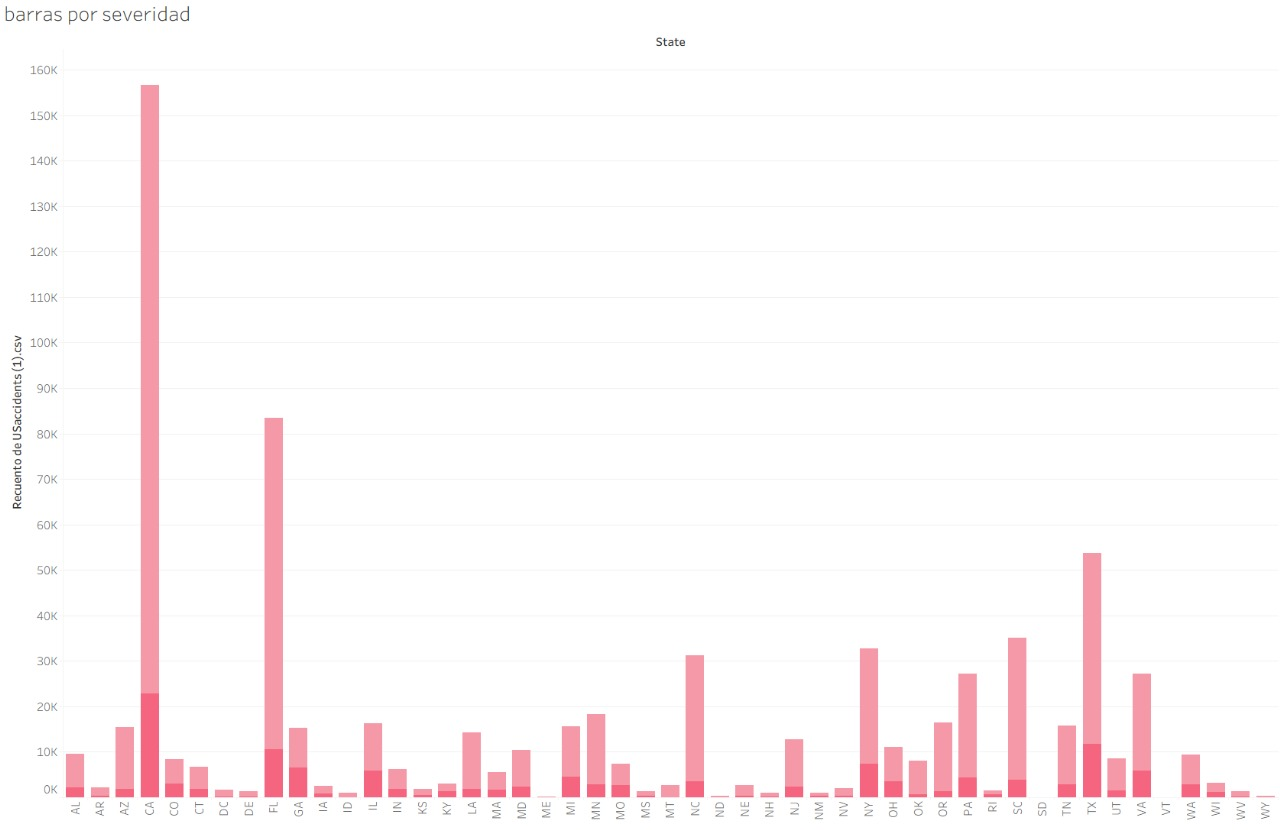

Gráfica de barras por severidad: compara el número de accidentes leves y graves en cada estado y ayuda a visualizar el desbalance de clases, evidenciando que los casos graves son menos comparado con el total.

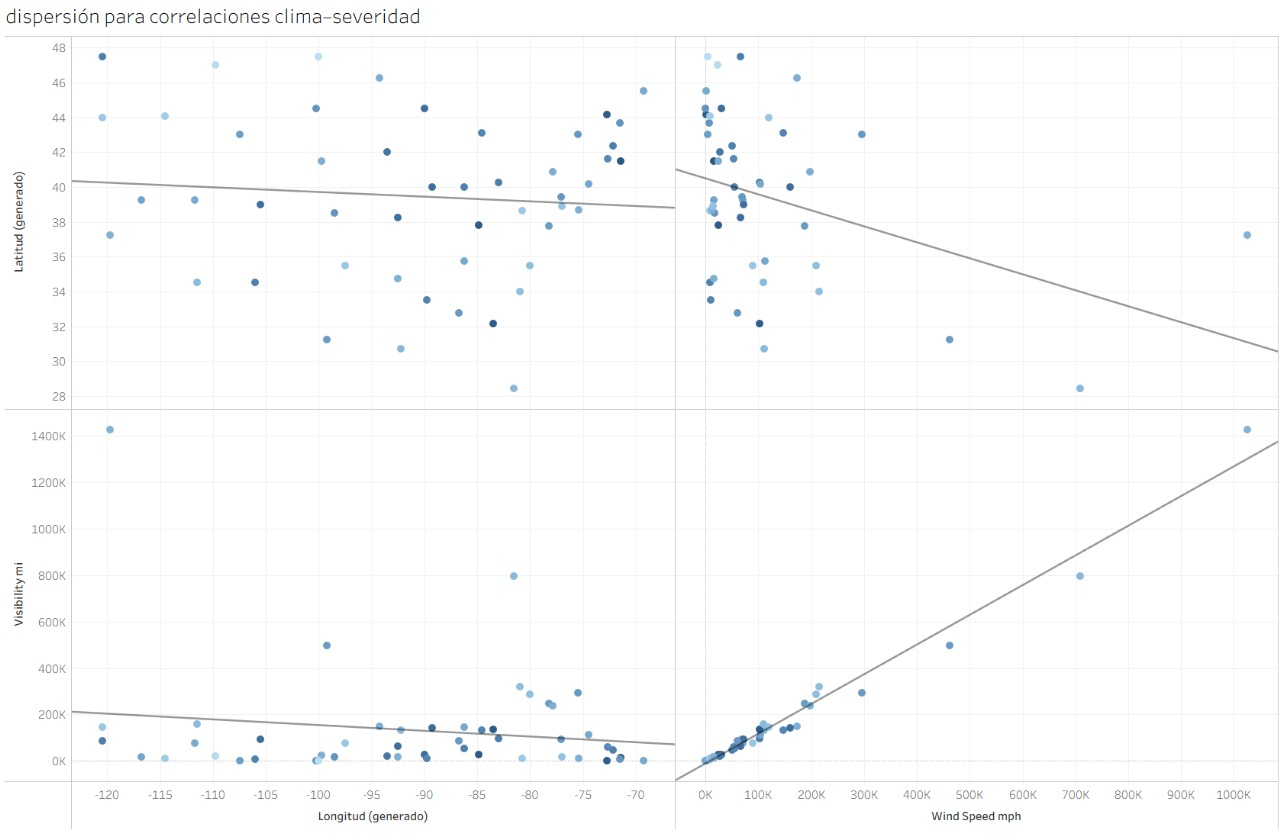

Gráfico de dispersión: representa la relación entre variables climáticas como velocidad del viento y visibilidad. Aunque los puntos no muestran una separación clara la visualización confirma que las condiciones del clima tienen influencia limitada sobre la gravedad.

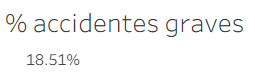

KPI: resumen del porcentaje total de accidentes graves en el país. Indica que aproximadamente el 18.5% de los accidentes registrados fueron clasificados como graves (niveles 3-4) y el 81.5% como leves.